In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.read_csv('data/prompts.csv')

,C,I,E,Q,T
0,You are an accomplished AI working as a human ...,Your task is to analyze some job description i...,This are the raw text from some job descriptio...,"This is the question: ""{Are the folowing job d...",Respond only with the exact binary label of ea...
1,You are an accomplished AI working as a lawyer...,Your task is to analyze some job descriptions ...,NaN,"This is the question: ""{Do the folowing job de...",NaN
2,You are an accomplished AI working as an Itali...,Your task is to analyze some job descriptions ...,NaN,"This is the question: ""{Classify the folowing ...",NaN
3,You are an accomplished AI working as a techni...,Your task is to analyze some job description i...,NaN,"This is the question: ""{Determine the binary l...",NaN
4,You are an accomplished AI working as a comput...,Your task is to analyze some job descriptions ...,NaN,"This is the question: ""{Which is the exact bin...",NaN
5,You are an accomplished AI working as a journa...,Your task is to revise some job descriptions i...,Here are the job descriptions: {job_desc},NaN,"You have to keep the structure {""job_decsripti..."
6,You are an accomplished AI working as an emplo...,NaN,NaN,NaN,NaN
7,You are an accomplished AI studying law in an ...,NaN,NaN,NaN,NaN
8,You are an accomplished AI living as a native ...,NaN,NaN,NaN,NaN
9,You are an accomplished AI working as a lawer ...,NaN,NaN,NaN,NaN


In [ ]:
count_columns = lambda df, cols: df.groupby(cols).size().reset_index(name='counts').sort_values('counts', ascending=False)

filter_full_prompts = lambda df, ps: df[df['prompt_id'].isin(ps)]

def filter_zsl_prompts(df, prompt_ids_subpart):
    res_df = pd.DataFrame()
    for p in prompt_ids_subpart:
        _df = df[df['prompt_id'].str.contains(f"_{p}_") | df['prompt_id'].str.endswith(f"_{p}")]
        res_df = pd.concat([res_df, _df])
    return res_df

def filter_target(df, targets): 
    if type(targets) == str:
        targets = [targets,]
    res_df = pd.DataFrame()
    for t in targets:
        _df = df[df['target'].str.contains(t)]
        res_df = pd.concat([res_df, _df])
    return res_df

LABELS = ['maschile', 'femminile', 'neutro']

def preprocess_label_df(df):
    #df = _df.copy()
    def improve(_x):
        x = _x['prediction']
        x = str(x).replace('"','').replace('*','').lower()
        if "maschile/femminile" in x:
            return "neutro"
        if "femminile/maschile" in x:
            return "neutro" 
        if "femminile/neutro" in x:
            return "neutro"
        if "maschile/neutro" in x:
            return "neutro"
        if "entrambi" in x:
            return "neutro"
        if x not in LABELS:
            return "none"
        return x
    df['prediction'] = df.apply(lambda x: improve(x), axis=1)
    df = df[df['prediction'] != 'none']
    return df

def valuate_label_results(df):
    accuracy = accuracy_score(df['ground_truth'], df['prediction'])
    f1 = f1_score(df['ground_truth'], df['prediction'], average='weighted')
    precision = precision_score(df['ground_truth'], df['prediction'], average='weighted')
    recall = recall_score(df['ground_truth'], df['prediction'], average='weighted')
    return accuracy, f1, precision, recall

def valuation_table(df, target_filters, inclusive=False):
    df = preprocess_label_df(df)

    if inclusive:
        df['ground_truth'] = df['ground_truth'].apply(lambda x: "inclusive" if x == "neutro" else "non inclusive")
        df['prediction'] = df['prediction'].apply(lambda x: "inclusive" if x == "neutro" else "non inclusive")

    res = pd.DataFrame({'target_filter':[],'accuracy': [], 'f1': [], 'precision': [], 'recall': []})
    res.loc[len(res)] = [None,] + list(valuate_label_results(df))
    for t in target_filters:
        res.loc[len(res)] = [t,] + list(valuate_label_results(filter_target(df, t)))
    return res

def analyze_label_results(df):

    sns.countplot(data=df, x='ground_truth')
    plt.show()

    print('Dataframe count:', len(df))
    df = preprocess_label_df(df)
    print('Dataframe count after preprocess:', len(df))

    sns.countplot(data=df, x='prediction')
    plt.show()

    cm = confusion_matrix(df['ground_truth'], df['prediction'], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
    disp.plot()
    plt.show()

    accuracy, f1, precision, recall = valuate_label_results(df)

    plt.table(cellText=[[accuracy, f1, precision, recall]], colLabels=['Accuracy', 'F1', 'Precision', 'Recall'], cellLoc='center', loc='bottom')
    plt.axis('off')
    plt.show()
    
    return count_columns(df, ['prediction'])

neutrals = ['giornaista',
            'autista',
            'dentista',
            'ginnasta',
            'consulente',
            'estetista',
            'farmacista',
            'contabile',
            'nutrizionista',
            'giardiniere',
            'insegnante',
            'igienista dentale']

In [70]:
df = pd.read_csv('results/llama3_synt.csv')

In [ ]:
df_ttl = filter_zsl_prompts(df, ['t0'])
count_columns(df_ttl, 'prediction')
#analyze_label_results(df_ttl)
#valuation_table(df_ttl, ['\*','/','Ã',' o ',neutrals], False)

analyze_label_results(df_ttl)
for t in ['\*','/','Ã',' o ',neutrals]:
       print('Analizing', t)
       #analyze_label_results(filter_target(df_ttl, t))

In [79]:
res = None
for p in df['prompt_id'].unique():
    if 't0' not in p and 't1' not in p and 't2' not in p:
        continue
    df_ttl = filter_full_prompts(df, [p])
    _res = valuation_table(df_ttl, ['\*','/','Ã',' o ',neutrals], False)
    _res['prompt_id'] = p
    if res is None:
        res = _res
    else:
        res = pd.concat([res, _res])
res.sort_values('f1', ascending=False).head(20)

,target_filter,accuracy,f1,precision,recall,prompt_id
3,Ã,1.000000,1.000000,1.000000,1.000000,c0_i0_e1_t2
2,/,1.000000,1.000000,1.000000,1.000000,c0_i0_e1_t2
1,\*,1.000000,1.000000,1.000000,1.000000,c0_i0_e1_t2
5,"[giornaista, autista, dentista, ginnasta, cons...",1.000000,1.000000,1.000000,1.000000,c0_i0_e0_t2
4,o,1.000000,1.000000,1.000000,1.000000,c0_i0_e0_t2
3,Ã,1.000000,1.000000,1.000000,1.000000,c0_i0_e0_t2
2,/,1.000000,1.000000,1.000000,1.000000,c0_i0_e0_t2
2,/,0.937778,0.967890,1.000000,0.937778,c0_i1_e0_q0_t0
4,o,0.937500,0.967742,1.000000,0.937500,c0_i0_e1_t2
3,Ã,0.920635,0.958678,1.000000,0.920635,c0_i1_e0_q0_t0


In [ ]:
assert 1 == 2

In [ ]:
def evaluate_labels(file_name):
    res_df = pd.read_csv('results/'+file_name+'.csv')
    def improve(x):
        x = str(x).replace('"','').replace('*','').lower()
        if "maschile/femminile" in x or "femminile/maschile" in x:
            return "neutro"
        return x
    # res_df['prediction'] = res_df['prediction'].apply(lambda x: improve(x))
    labels = res_df['ground_truth'].unique()
    # res_df_filtered = res_df[~res_df['prediction'].isin(labels)]
    res_df_filtered = res_df[res_df['prediction'].isin(labels)]
    print('removed',(len(res_df)-len(res_df_filtered))/len(res_df))
    # print(res_df_filtered['ground_truth'].unique())
    
    def valuate_prompt(prompt_id):
        _df = res_df_filtered[res_df_filtered['prompt_id'] == prompt_id]
        print(prompt_id,'len',len(_df))
        print('Accuracy:', accuracy_score(_df['ground_truth'], _df['prediction']))
        print('F1:', f1_score(_df['ground_truth'], _df['prediction'], average='weighted'))
        print('Precision:', precision_score(_df['ground_truth'], _df['prediction'], average='weighted'))
        print('Recall:', recall_score(_df['ground_truth'], _df['prediction'], average='weighted'))
        cm = confusion_matrix(_df['ground_truth'], _df['prediction'], normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        # wrong = res_df_job[res_df_job['ground_truth'] != res_df_job['prediction']]
        # print('len', len(wrong))
        disp.plot()
        plt.show()

    #valuate_tag('job')
    #valuate_tag('job+line')
    print('results for',file_name)
    print('')
    for prompt_id in res_df_filtered['prompt_id'].unique():
        valuate_prompt(prompt_id)
    

In [ ]:
evaluate_labels('llama3_synt')

FileNotFoundError: [Errno 2] No such file or directory: 'results/ttl_llama3_synt.csv'

removed 0.33641975308641975
results for ttl_gemma_synt

0 len 404
Accuracy: 0.5544554455445545
F1: 0.5612010002020611
Precision: 0.6092346671169294
Recall: 0.5544554455445545


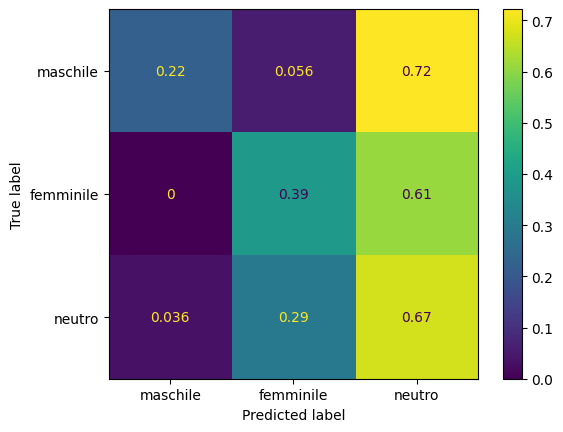

1 len 403
Accuracy: 0.43672456575682383
F1: 0.4494351210869612
Precision: 0.6554828153745067
Recall: 0.43672456575682383


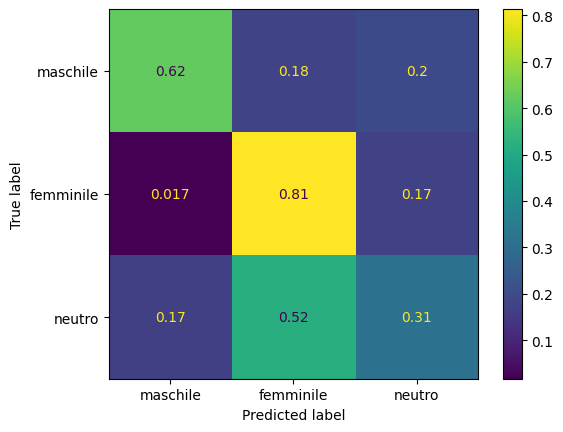

2 len 483
Accuracy: 0.5755693581780539
F1: 0.5329838912862604
Precision: 0.5664921295999985
Recall: 0.5755693581780539


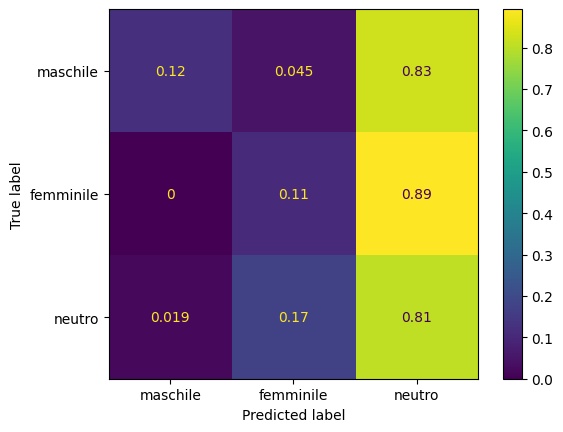

In [ ]:
evaluate_labels('ttl_gemma_synt')

In [ ]:
res_df = pd.read_csv('results/ttl_gemma_synt.csv')
# tab of value count of predictions
res_df.groupby('prediction').count().sort_values('prompt_id', ascending=False).head(20)

,text,ground_truth,prompt_id
prediction,,,
Neutro,400,400,400
neutro,378,378,378
maschile,348,348,348
femminile,107,107,107
Maschile,29,29,29
Femminile,25,25,25
Non è possibile determinare il genere del pubblico dal testo fornito.,7,7,7
architetto,6,6,6
Neutro.,6,6,6
